In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Dense, BatchNormalization, Activation, GlobalAveragePooling1D, Dropout, Normalization

In [15]:
seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [16]:
basedir = r"C:\Users\tmhnguyen\Documents\lalamove\lalamove\data\Clean_extracted_240115_uncal\train"
labels = [5, 6, 7]
synthetic_percent = {5: 0.8, 6: 0.1, 7: 0.5}
with open(basedir + '/../data_split_params.json', 'r') as file:
    features = json.load(file)['FEATURES']
print(features)

{'5': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '6': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '7': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']}


In [17]:
label = 6

In [18]:
y_ori = pd.read_csv(basedir + f'/{label}/train_label_{label}.csv')
X_ori = []
step = 30_000
for i in range(np.ceil(len(y_ori)/30_000).astype(int)):
    temp = pd.read_csv(basedir + f'/{label}/extract_features_{label}_{i}.csv', index_col=0)
    X_ori.append(temp)
X_ori = pd.concat(X_ori)
assert len(X_ori) == len(y_ori), f"Length mismatch {len(X_ori)}, {len(y_ori)}"

In [19]:
def create_model(xtrain, input_shape=500):
    inputs = Input(shape=input_shape)
    scaler = Normalization()
    scaler.adapt(xtrain)
    scaled_inputs = scaler(inputs)
    x = Dense(500, activation='relu')(scaled_inputs)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    return model

In [20]:
dates = y_ori.date.unique()
test_date = dates[-3]
test_idx = y_ori[(y_ori.date == test_date) & (y_ori.type == 0)].index

X_test = X_ori.iloc[test_idx]
y_test = y_ori.iloc[test_idx].label

y = y_ori[y_ori.date != test_date].reset_index()
X = X_ori.iloc[y.index]

print('test date is ', test_date, X_ori.shape, y_ori.shape, X.shape, y.shape)

test date is  20231228 (389287, 500) (389287, 6) (368768, 500) (368768, 7)


In [21]:
models = []
alphas = []
n_models = len(dates) - 1
rand_states = np.random.randint(1, 10000, size=n_models)
for i, val_date in enumerate([d for d in dates if d != test_date]):
    print(f'{i+1}th model in the ensemble', val_date)
    tf.keras.backend.clear_session() # release resource associated with previous model
    
    val_idx = y[(y.date == val_date) & (y.type == 0)].index
    train_idx = y[(y.date != val_date) & (y.type == 0)]
    train_idx_add = y[(y.date != val_date) & (y.type == 1)].sample(frac=synthetic_percent[label])
    train_idx = pd.concat([train_idx, train_idx_add]).index

    X.iloc[val_idx].to_numpy()
    X.iloc[train_idx_add.index].to_numpy()

    X_train_en, X_val = X.iloc[train_idx].to_numpy(), X.iloc[val_idx].to_numpy()
    y_train_en, y_val = y.iloc[train_idx].label.to_numpy(), y.iloc[val_idx].label.to_numpy()
    
    print(X_train_en.shape, X_val.shape)

    model = create_model(X_train_en, input_shape=X_train_en.shape[1])

    model.compile(optimizer=Adam(learning_rate=2e-5),
                loss='binary_crossentropy',
                metrics=[BinaryAccuracy(name='acc'),
                        Precision(name='precision'),
                        Recall(name='recall')])

    history = model.fit(X_train_en, y_train_en, batch_size=256, epochs=5, validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(patience=20,
                                        min_delta=0.0005,
                                        restore_best_weights=True)],
                        verbose=False)
    loss_v, acc_v, precision_v, recall_v = model.evaluate(X_val, y_val)

    # Compute the weighted error of the weak classifier
    predictions = (model.predict(X_train_en) >= 0.5).flatten().astype(int)
    weighted_error = np.sum(predictions != y_train_en) / len(X_train_en)
    
    # Compute the model weight of the weak classifier
    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
    alphas.append(alpha)

    # print(f' on validation set - loss: {loss_v:.4f}, accuracy: {acc_v:.4f}, precision: {precision_v:.4f}, recal: {recall_v:.4f}')
    model.save(basedir + f'/../model_ann_ensemble/{label}/model_{label}_no_{i}.hdf5')
    models.append(model)

1th model in the ensemble 20231107
(243182, 500) (14532, 500)
7600/7600 [==============================] - 9s 1ms/step
2th model in the ensemble 20231115
(243265, 500) (14575, 500)
3657/7603 [=============>................] - ETA: 4s

In [ ]:
def ensemble_predict(models, alphas, xtest):
    ensemble_predictions = np.mean([model.predict(xtest)*alpha for model, alpha in zip(models, alphas)], axis=0)
    return ensemble_predictions


In [ ]:
# normalized model weights
alphas = np.array(alphas)
alphas = alphas / alphas.sum()
dates, alphas

array([20231107, 20231115, 20231116, 20231117, 20231120, 20231121,
       20231122, 20231124, 20231127, 20231128, 20231129, 20231201,
       20231204, 20231205, 20231227, 20231228, 20231229, 20240104],
      dtype=int64)

427/427 [==============================] - 1s 1ms/step


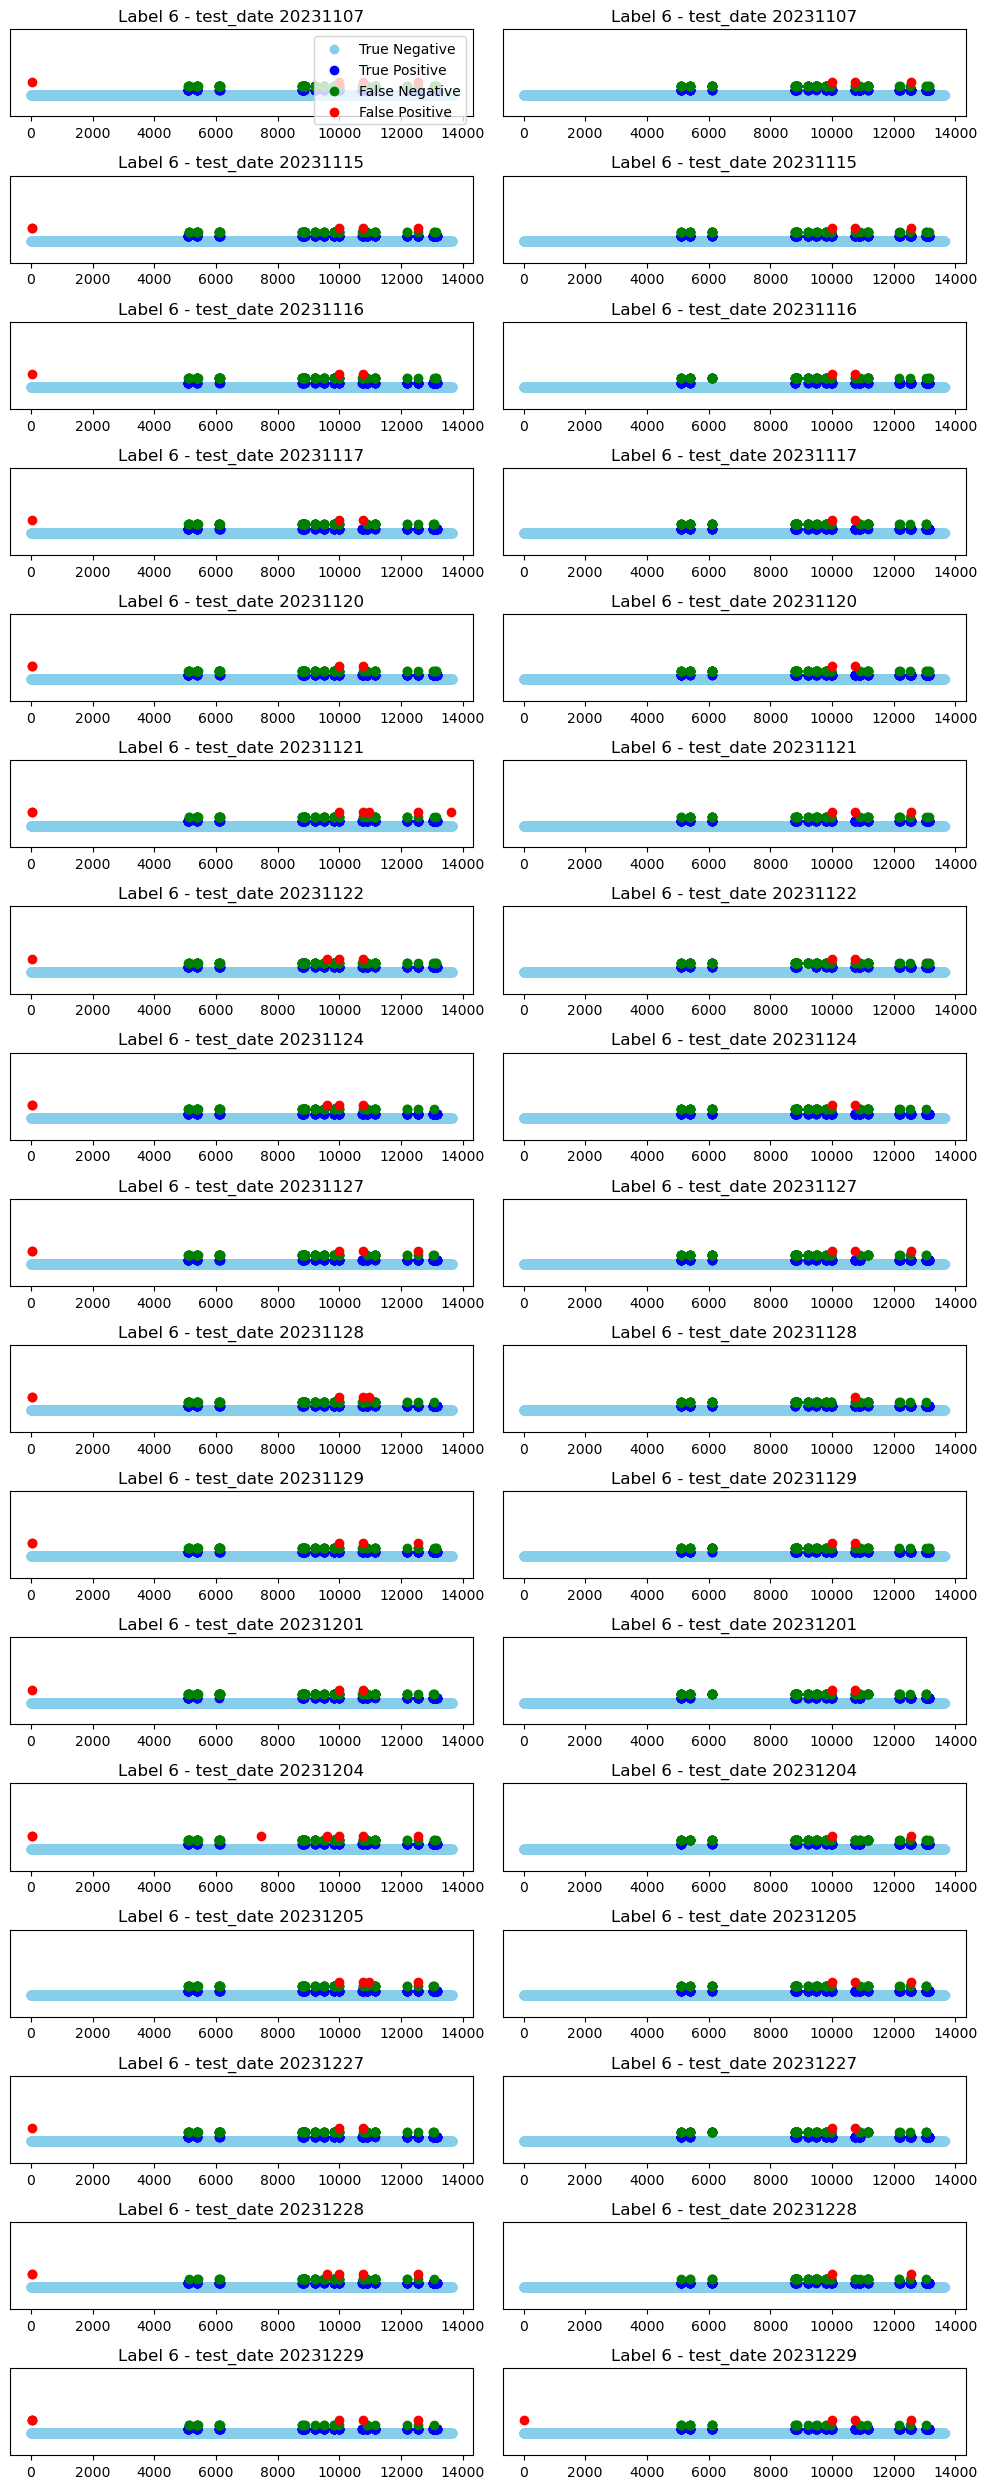

In [ ]:
def classify(row, col='pred'):
    true, pred = row.true, row[col]
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'


fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(10, 25))
for k, model in enumerate(models):    
    pred = model.predict(X_test) >= 0.5
    df = pd.DataFrame(np.hstack((y_test.to_numpy().reshape(-1, 1), pred)), columns=['true', 'pred'])
    df.pred = df.pred.astype(int)        
    df['type'] = df.apply(lambda x: classify(x), axis=1)
    types = df.type.value_counts().sort_index()[::-1]

    w = 5 # window in seconds
    pred_avg = np.convolve(pred.flatten(), np.ones(w), mode='same') / w >= 0.5
    df['pred_avg'] = pred_avg
    df.pred_avg = df.pred_avg.astype(int)        
    df['type_avg'] = df.apply(lambda x: classify(x, col='pred_avg'), axis=1)
    types_avg = df.type_avg.value_counts().sort_index()[::-1]

    colors = ['skyblue', 'blue', 'green', 'red']
    types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

    i = 0.5
    for j, t in enumerate(types_):
        try:
            axes[k, 0].scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
        except KeyError:
            pass
        i += 0.1

    axes[k, 0].set_ylim(0, 2)
    axes[k, 0].get_yaxis().set_visible(False)
    axes[k, 0].set_title(f'Label {label} - test_date {dates[k]}')

    i = 0.5
    for j, t in enumerate(types_):
        try:
            axes[k, 1].scatter(df[df.type_avg==t].index, [i]*types_avg[t], label=t, c=colors[j])
        except KeyError:
            pass
        i += 0.1

    axes[k, 1].set_ylim(0, 2)
    axes[k, 1].get_yaxis().set_visible(False)
    axes[k, 1].set_title(f'Label {label} - test_date {dates[k]}')  

axes[0, 0].legend()
plt.tight_layout()

In [ ]:
pred = ensemble_predict(models, alphas, X_test) >= 0.5
print(pred.shape, y_test.shape)

df = pd.DataFrame(np.hstack((y_test.to_numpy().reshape(-1, 1), pred)), columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        pass
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{label} NO average smoothing')


In [ ]:
pred = ensemble_predict(models, alphas, X_test).flatten() 
print(pred.shape, y_test.shape)
w = 5 # window in seconds
pred = np.convolve(pred, np.ones(w), mode='same') / w >= 0.5

print(pred.shape, y_test.shape)
df = pd.DataFrame(np.stack((y_test, pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        print(f'There is no {t}')
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{label} with average smoothing')